In [1]:
import logging
import os
from itertools import product
from pathlib import Path
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import stats
import matplotlib as mpl
import polars as pl

os.chdir("/root/py_projects/aihiii")

import src.utils.json_util as json_util
from src._StandardNames import StandardNames
from src.utils.custom_log import init_logger
from src.utils.ParquetHandler import ParquetHandler
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams

LOG: logging.Logger = logging.getLogger(__name__)
init_logger(log_lvl=logging.INFO)
set_rcparams()

STR: StandardNames = StandardNames()

HIII_DIR: Path = PathChecker().check_directory(Path("data/doe/doe_sobol_20240705_194200"))
VH_DIR: Path = PathChecker().check_directory(Path("data/doe/virthuman"))
HIII_TEST_DIR: Path = PathChecker().check_directory(Path("data/doe/doe_sobol_test_20240829_135200"))

2024-09-14 17:29:28,910     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2024-09-14 17:29:28,947     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle
2024-09-14 17:29:28,948     INFO  MainProcess  MainThread Directory 'data/doe/doe_sobol_20240705_194200' exists
2024-09-14 17:29:28,949     INFO  MainProcess  MainThread Directory 'data/doe/virthuman' exists
2024-09-14 17:29:28,950     INFO  MainProcess  MainThread Directory 'data/doe/doe_sobol_test_20240829_135200' exists


In [2]:
REL_COLS: Dict[str, str] = {
    "Head_HIC15": "1",
    "Head_HIC36": "1",
    "Head_a3ms": "g",
    "Neck_Nij": "1",
    "Neck_Fz_Max_Compression": "kN",
    "Neck_Fz_Max_Tension": "kN",
    "Neck_My_Max": "Nm",
    "Neck_Fx_Shear_Max": "kN",
    "Chest_Deflection": "mm",
    "Chest_a3ms": "g",
    "Femur_Fz_Max_Compression": "kN",
    "Femur_Fz_Max_Tension": "kN",
    "Femur_Fz_Max": "kN",
    "Chest_VC": "m/s",
}

DOE_COLS: Dict[str, str] = {
    "PAB_M_Scal": "1",
    "PAB_Vent_T": "s",
    "Pulse_Angle": "deg",
    "Pulse_X_Scale": "1",
    "SLL": "kN",
}

2024-09-14 17:29:28,998     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2024-09-14 17:29:29,552     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-14 17:29:29,578     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-14 17:29:29,766     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-14 17:29:29,789     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all pars

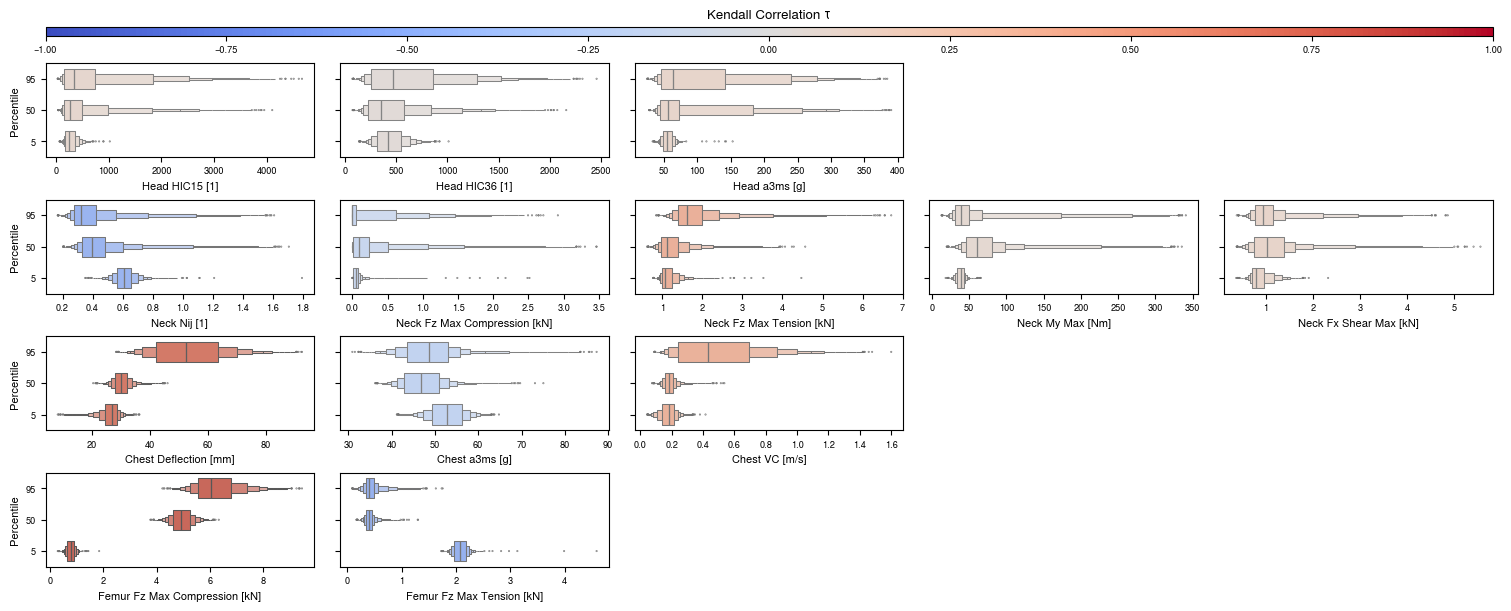

In [3]:
def plot_perc2inj2(d_dir: Path, lims=None):
    drop_fpath = d_dir / STR.fname_dropped_ids
    if drop_fpath.is_file():
        drops = json_util.load(f_path=drop_fpath)
        drops = sum([list(product(drops[perc], [int(perc)])) for perc in drops.keys()], [])
        drops = pd.MultiIndex.from_tuples(drops)

    db = ParquetHandler(path=d_dir / STR.fname_injury_crit).read(columns=list(REL_COLS.keys()))
    if drop_fpath.is_file():
        db.drop(index=drops, inplace=True)
    chs = sorted(set(db.columns) - {"Femur_Fz_Max"})
    db.reset_index(inplace=True)
    db[STR.perc] = db[STR.perc].astype(int).astype(str)

    ch_scheme = [
        ["color"] * 5,
        ["Head_HIC15", "Head_HIC36", "Head_a3ms", "1", "5"],
        ["Neck_Nij", "Neck_Fz_Max_Compression", "Neck_Fz_Max_Tension", "Neck_My_Max", "Neck_Fx_Shear_Max"],
        ["Chest_Deflection", "Chest_a3ms", "Chest_VC", "3", "6"],
        ["Femur_Fz_Max_Compression", "Femur_Fz_Max_Tension", "9", "4", "7"],
    ]
    fsts = set([chs[0] for chs in ch_scheme[1:]])

    fig, ax = plt.subplot_mosaic(
        mosaic=ch_scheme,
        figsize=(15, 6),
        layout="constrained",
        gridspec_kw={"height_ratios": (0.1, *([1] * 4))},
    )
    cmap = mpl.colormaps["coolwarm"]
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(mappable=sm, cax=ax["color"], orientation="horizontal")
    ax["color"].set_title("Kendall Correlation τ")
    if lims is None:
        with_lim = False
        lims = {}
    else:
        with_lim = True
    for ch in chs:
        cor = stats.kendalltau(db[ch], db[STR.perc]).statistic
        sns.boxenplot(
            data=db,
            y=STR.perc,
            x=ch,
            ax=ax[ch],
            gap=0.2,
            color=cmap((cor + 1) * 0.5),
            flier_kws={"s": .2},
        )
        ax[ch].set_xlabel(f"{ch.replace('_', ' ')} [{REL_COLS[ch]}]")
        # ax[ch].set_xlabel("")
        ax[ch].invert_yaxis()
        if ch in fsts:
            ax[ch].set_ylabel("Percentile")
        else:
            ax[ch].set_ylabel("")
            ax[ch].set_yticklabels([])
        if with_lim:
            ax[ch].set_xlim(lims[ch])
        else:
            lims[ch] = ax[ch].get_xlim()
            
    for sch in ch_scheme:
        for ch in sch:
            if ch not in list(REL_COLS.keys()) + ["color"]:
                ax[ch].set_axis_off()

    return lims


dev_lim = plot_perc2inj2(d_dir=HIII_DIR)

2024-09-14 17:46:54,325     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_test_20240829_135200/injury_criteria.parquet' exists
2024-09-14 17:46:54,976     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-14 17:46:54,981     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-14 17:46:55,032     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-14 17:46:55,037     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all

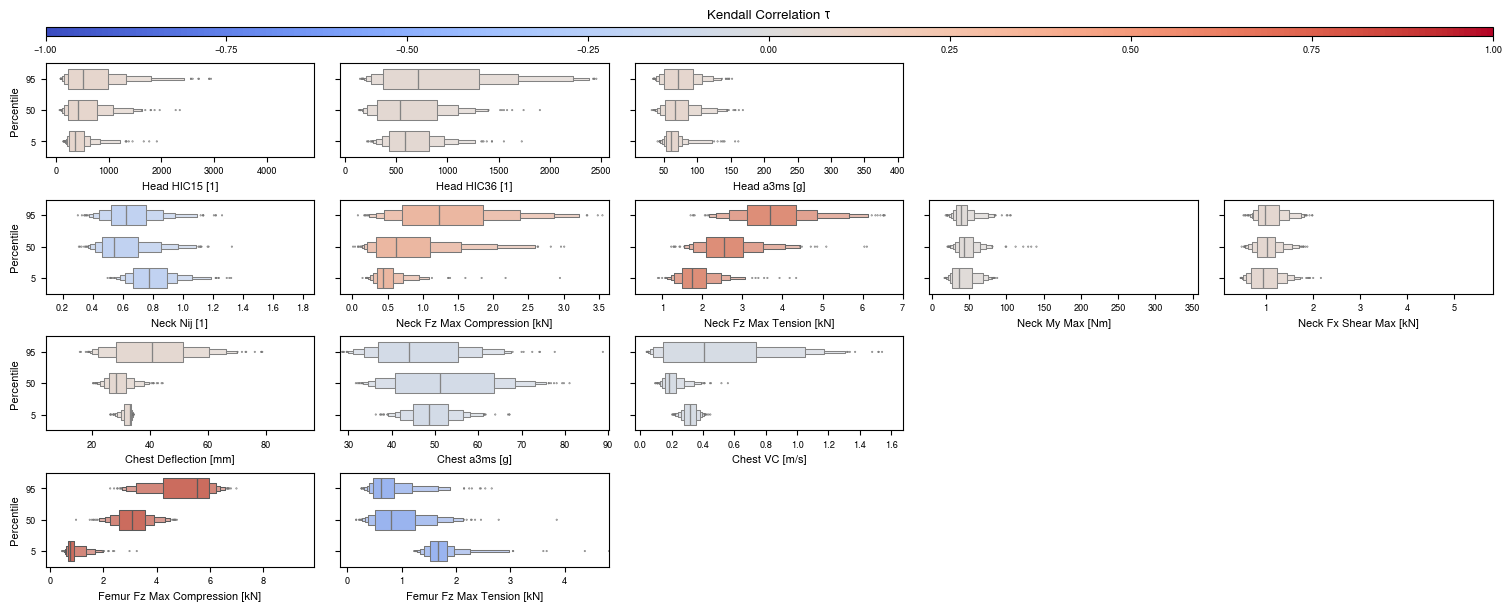

In [14]:
_ = plot_perc2inj2(d_dir=HIII_TEST_DIR, lims=dev_lim)

2024-09-14 17:29:36,915     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


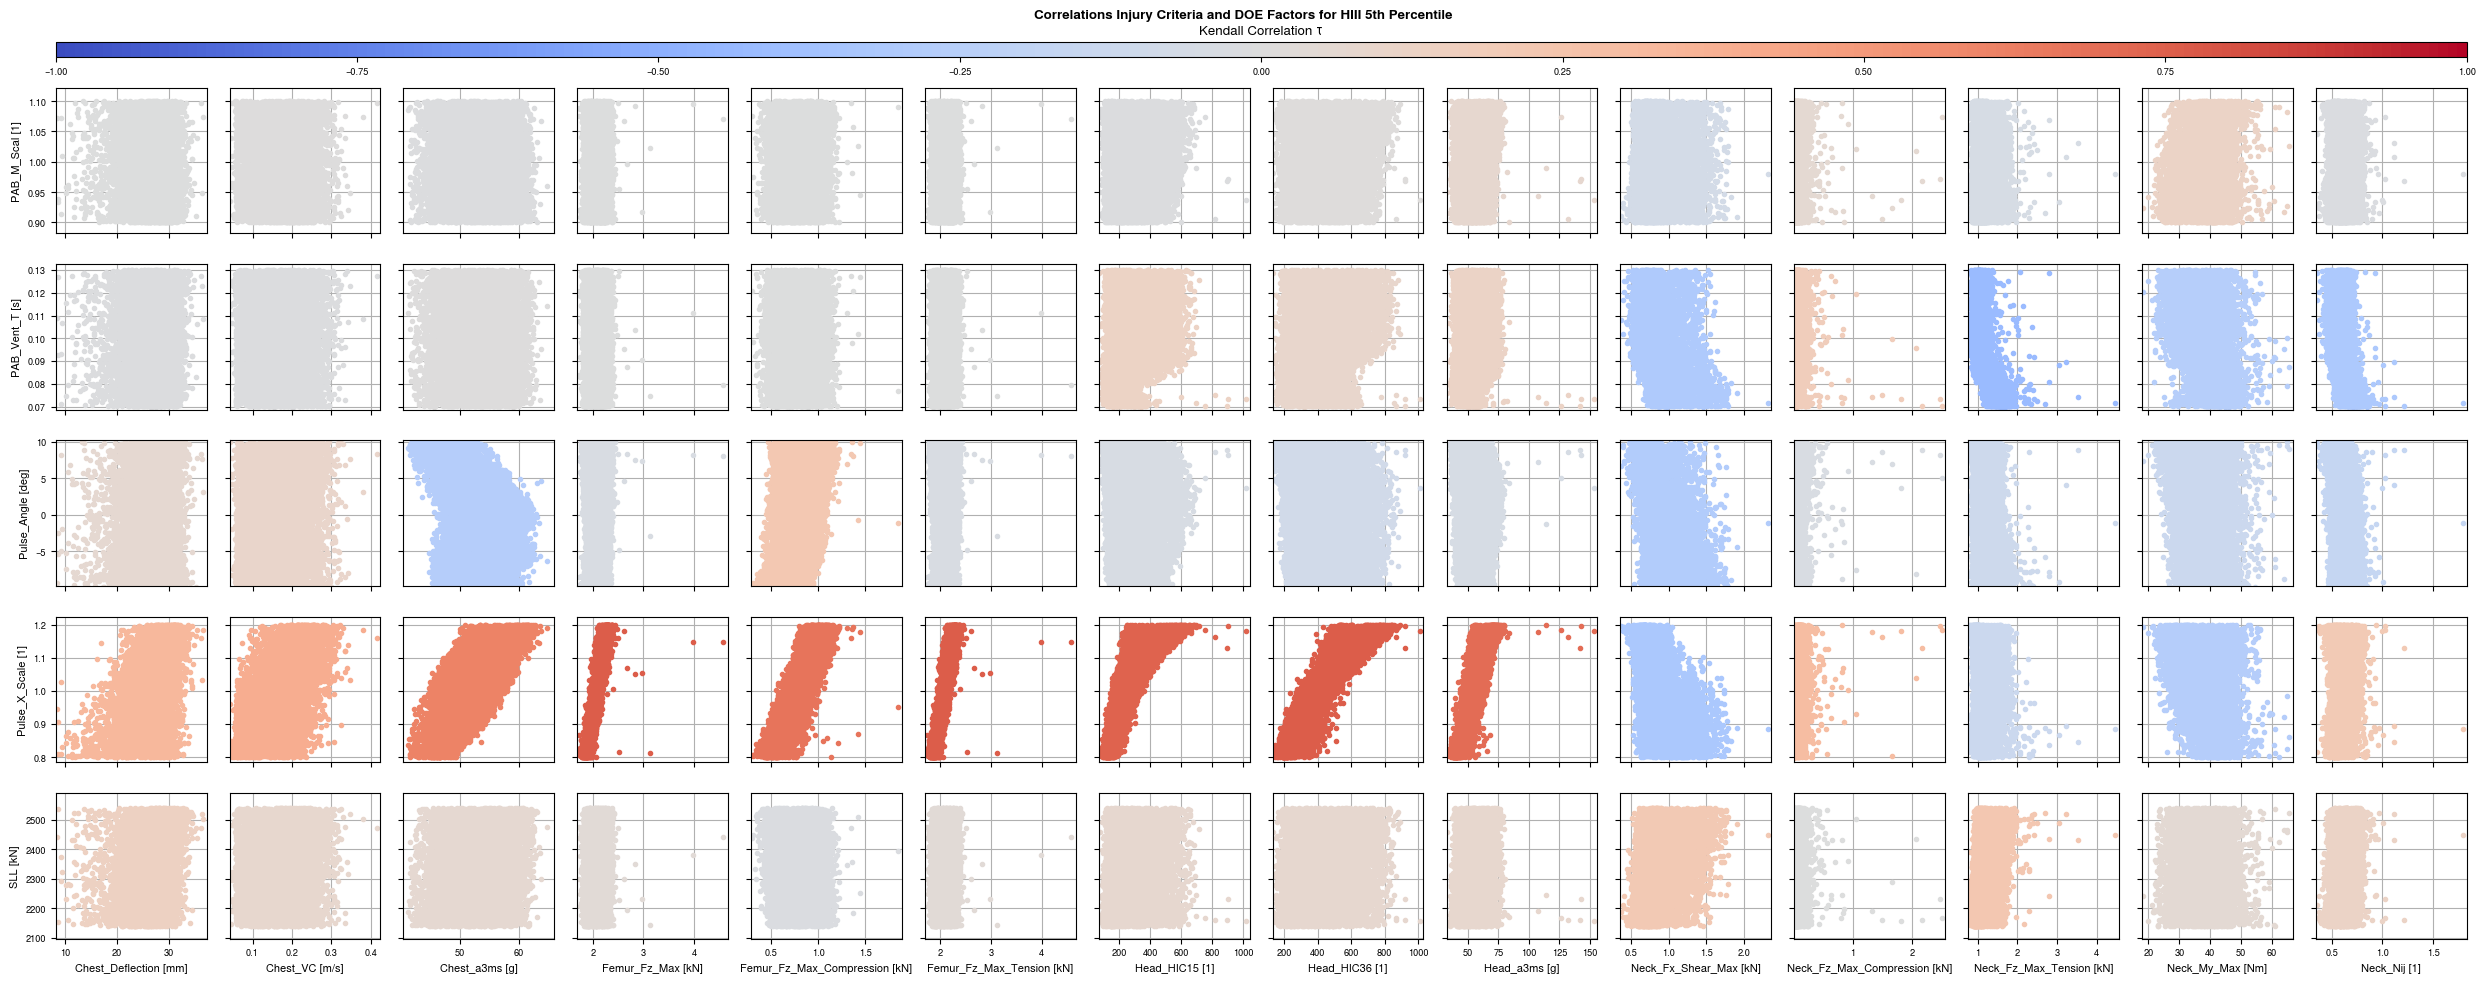

In [5]:
def to_doe_fance(d_dir: Path, perc: int):

    # data
    drops = json_util.load(f_path=d_dir / STR.fname_dropped_ids)[str(perc)]
    inj_vals = ParquetHandler(path=d_dir / STR.fname_injury_crit).read(columns=REL_COLS, percentiles=[perc]).drop(index=drops)
    doe = pd.read_parquet(d_dir / "doe_combined.parquet", filters=[(STR.perc, "==", perc)]).drop(columns=[STR.perc])
    parser = pd.read_parquet(d_dir / STR.fname_sim_id_2_id, filters=[(STR.perc, "==", perc)]).drop(columns=[STR.perc])
    doe = doe.join(parser, on=STR.sim_id).set_index(STR.id).drop(index=drops)
    del parser

    # ranges
    inj_ranges = {c: (inj_vals[c].min() * 0.98, inj_vals[c].max() * 1.02) for c in inj_vals.columns}
    doe_ranges = {c: (doe[c].min() * 0.98, doe[c].max() * 1.02) for c in doe.columns}
    inj_cols = sorted(inj_vals.columns)
    doe_cols = sorted(doe.columns)

    # prepare plot
    p_width = (448.13095 / 72) * 4
    fields = [[f"{d}_{i}" for i in inj_cols] for d in doe_cols]
    fields = [["color"] * inj_vals.shape[1]] + fields
    fig, ax = plt.subplot_mosaic(
        mosaic=fields,
        figsize=(p_width, 0.4 * p_width),
        # layout="constrained",
        gridspec_kw={"height_ratios": (0.1, *([1] * doe.shape[1]))},
    )
    fig.suptitle(f"Correlations Injury Criteria and DOE Factors for HIII {perc}th Percentile")

    # colorbar
    cmap = mpl.colormaps["coolwarm"]
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(mappable=sm, cax=ax["color"], orientation="horizontal")
    ax["color"].set_title("Kendall Correlation τ")

    # generate plot
    for inj_col, doe_col in product(inj_cols, doe_cols):
        ax_ = ax[f"{doe_col}_{inj_col}"]
        # plot
        cor = stats.kendalltau(inj_vals[inj_col].loc[doe.index], doe[doe_col]).statistic
        ax_.scatter(inj_vals[inj_col].loc[doe.index], doe[doe_col], color=cmap((cor + 1) * 0.5), marker=".")

        # format
        ax_.set_xlim(inj_ranges[inj_col])
        ax_.set_ylim(doe_ranges[doe_col])
        ax_.grid()
        ax_.set_axisbelow(True)
        if inj_col == inj_cols[0]:
            ax_.set_ylabel(f"{doe_col} [{DOE_COLS[doe_col]}]")
        if inj_col != inj_cols[0]:
            ax_.set_yticklabels([])
        if doe_col == doe_cols[-1]:
            ax_.set_xlabel(f"{inj_col} [{REL_COLS[inj_col]}]")
        if doe_col != doe_cols[-1]:
            ax_.set_xticklabels([])

    fig.tight_layout()


to_doe_fance(d_dir=HIII_DIR, perc=5)

2024-09-14 17:29:45,939     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


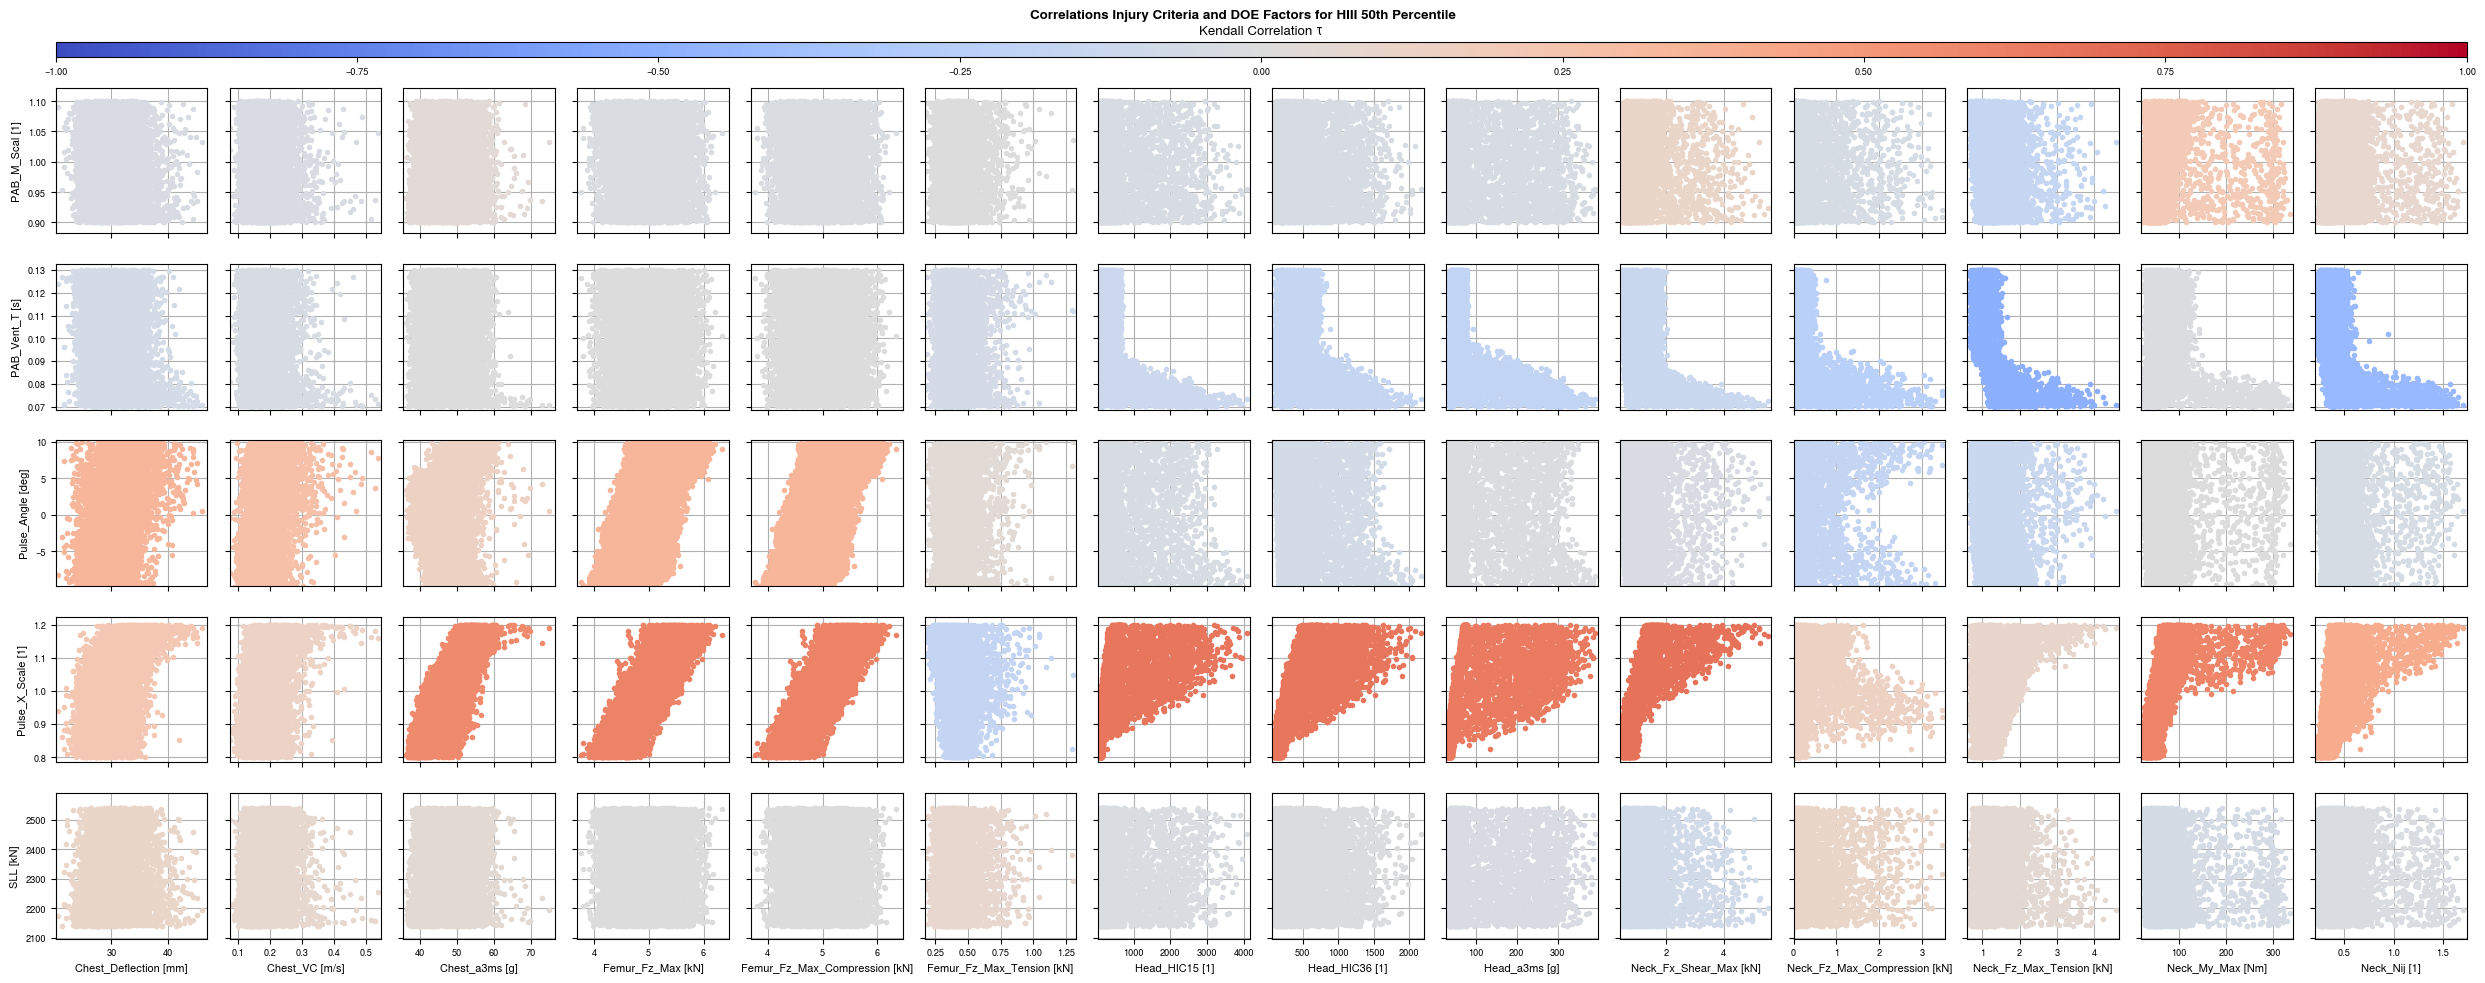

In [6]:
to_doe_fance(d_dir=HIII_DIR, perc=50)

2024-09-14 17:29:54,736     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


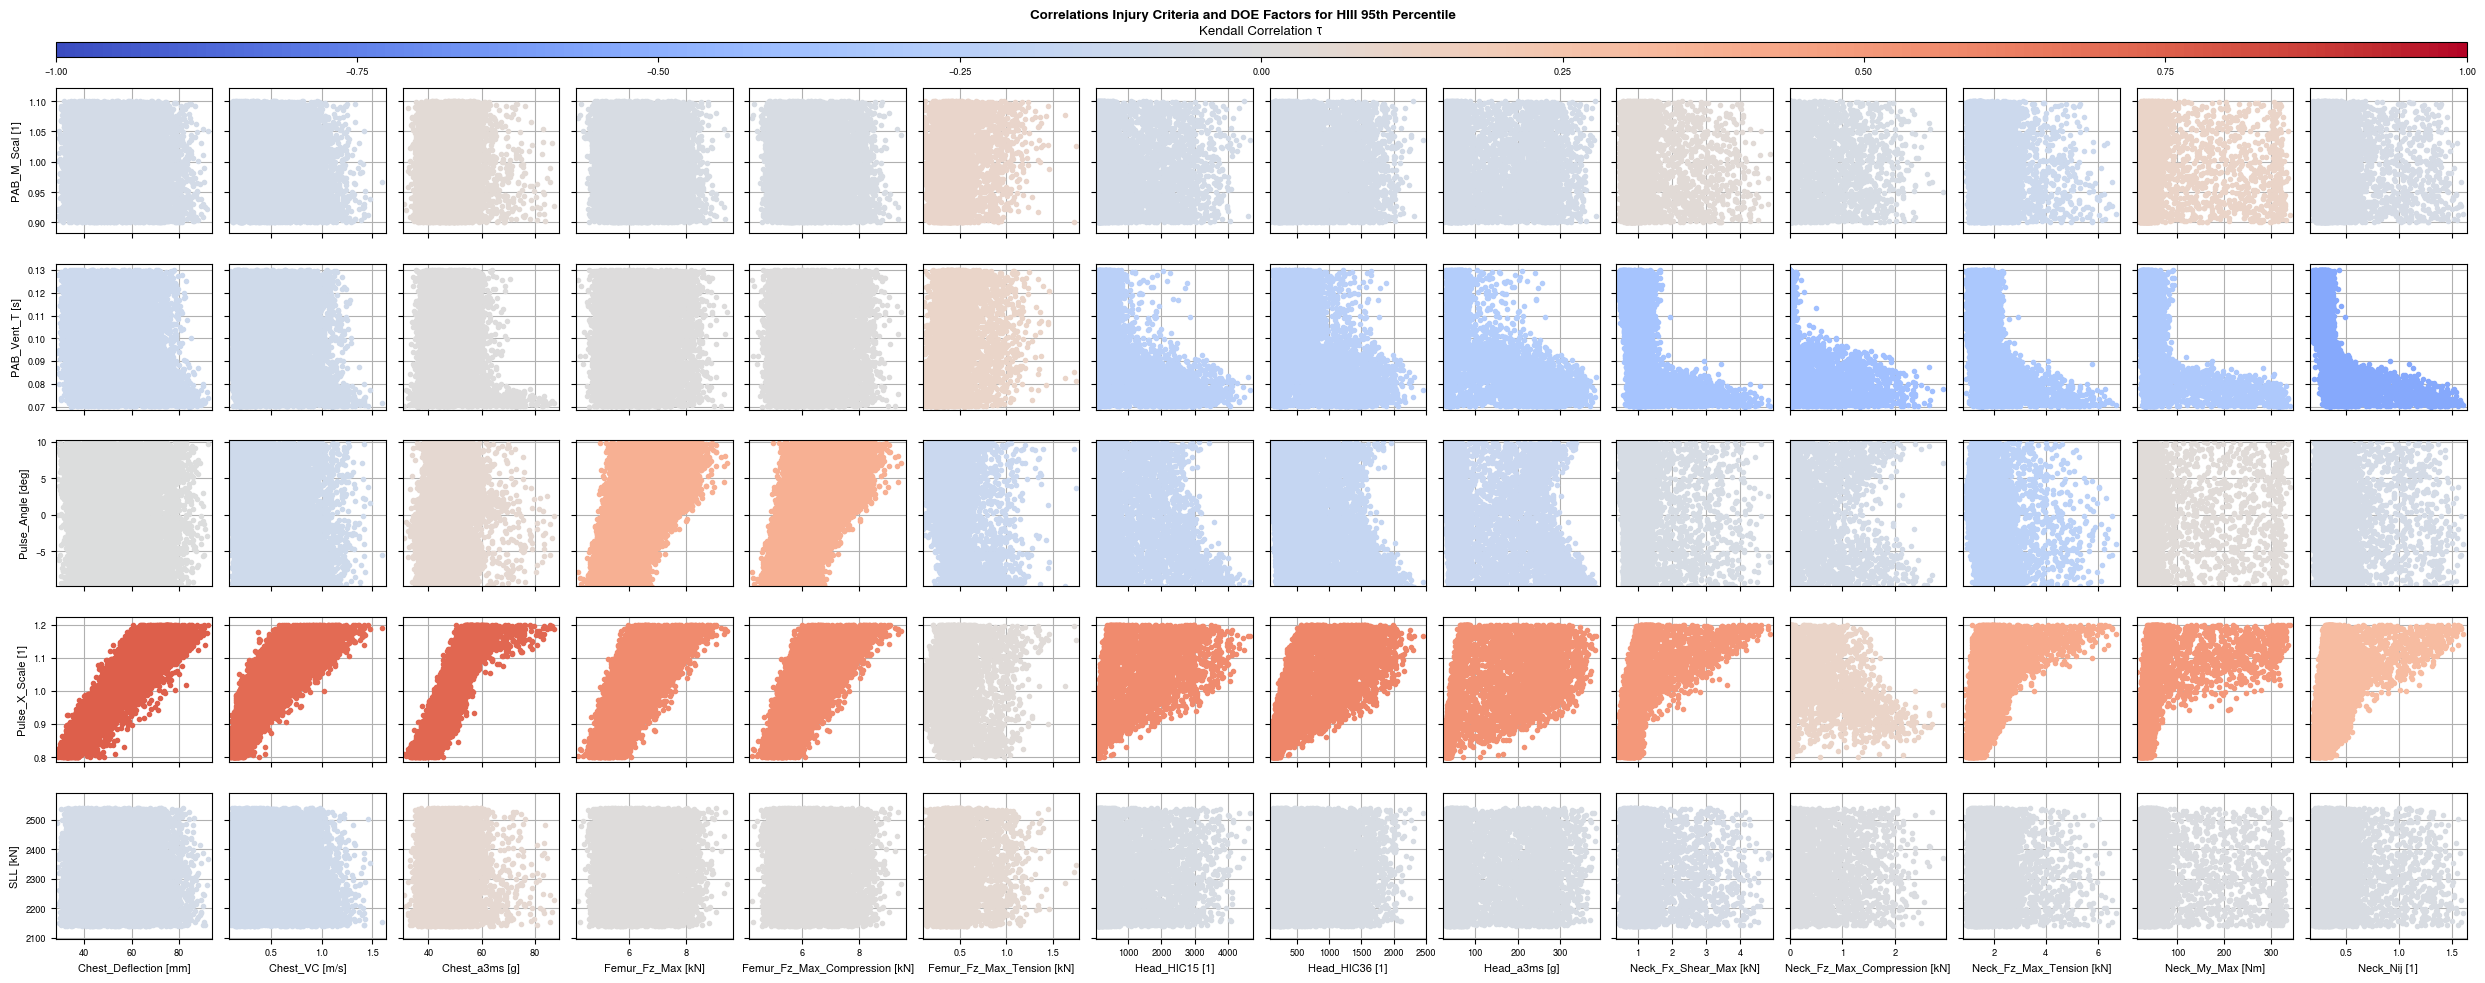

In [7]:
to_doe_fance(d_dir=HIII_DIR, perc=95)

2024-09-14 17:30:02,669     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


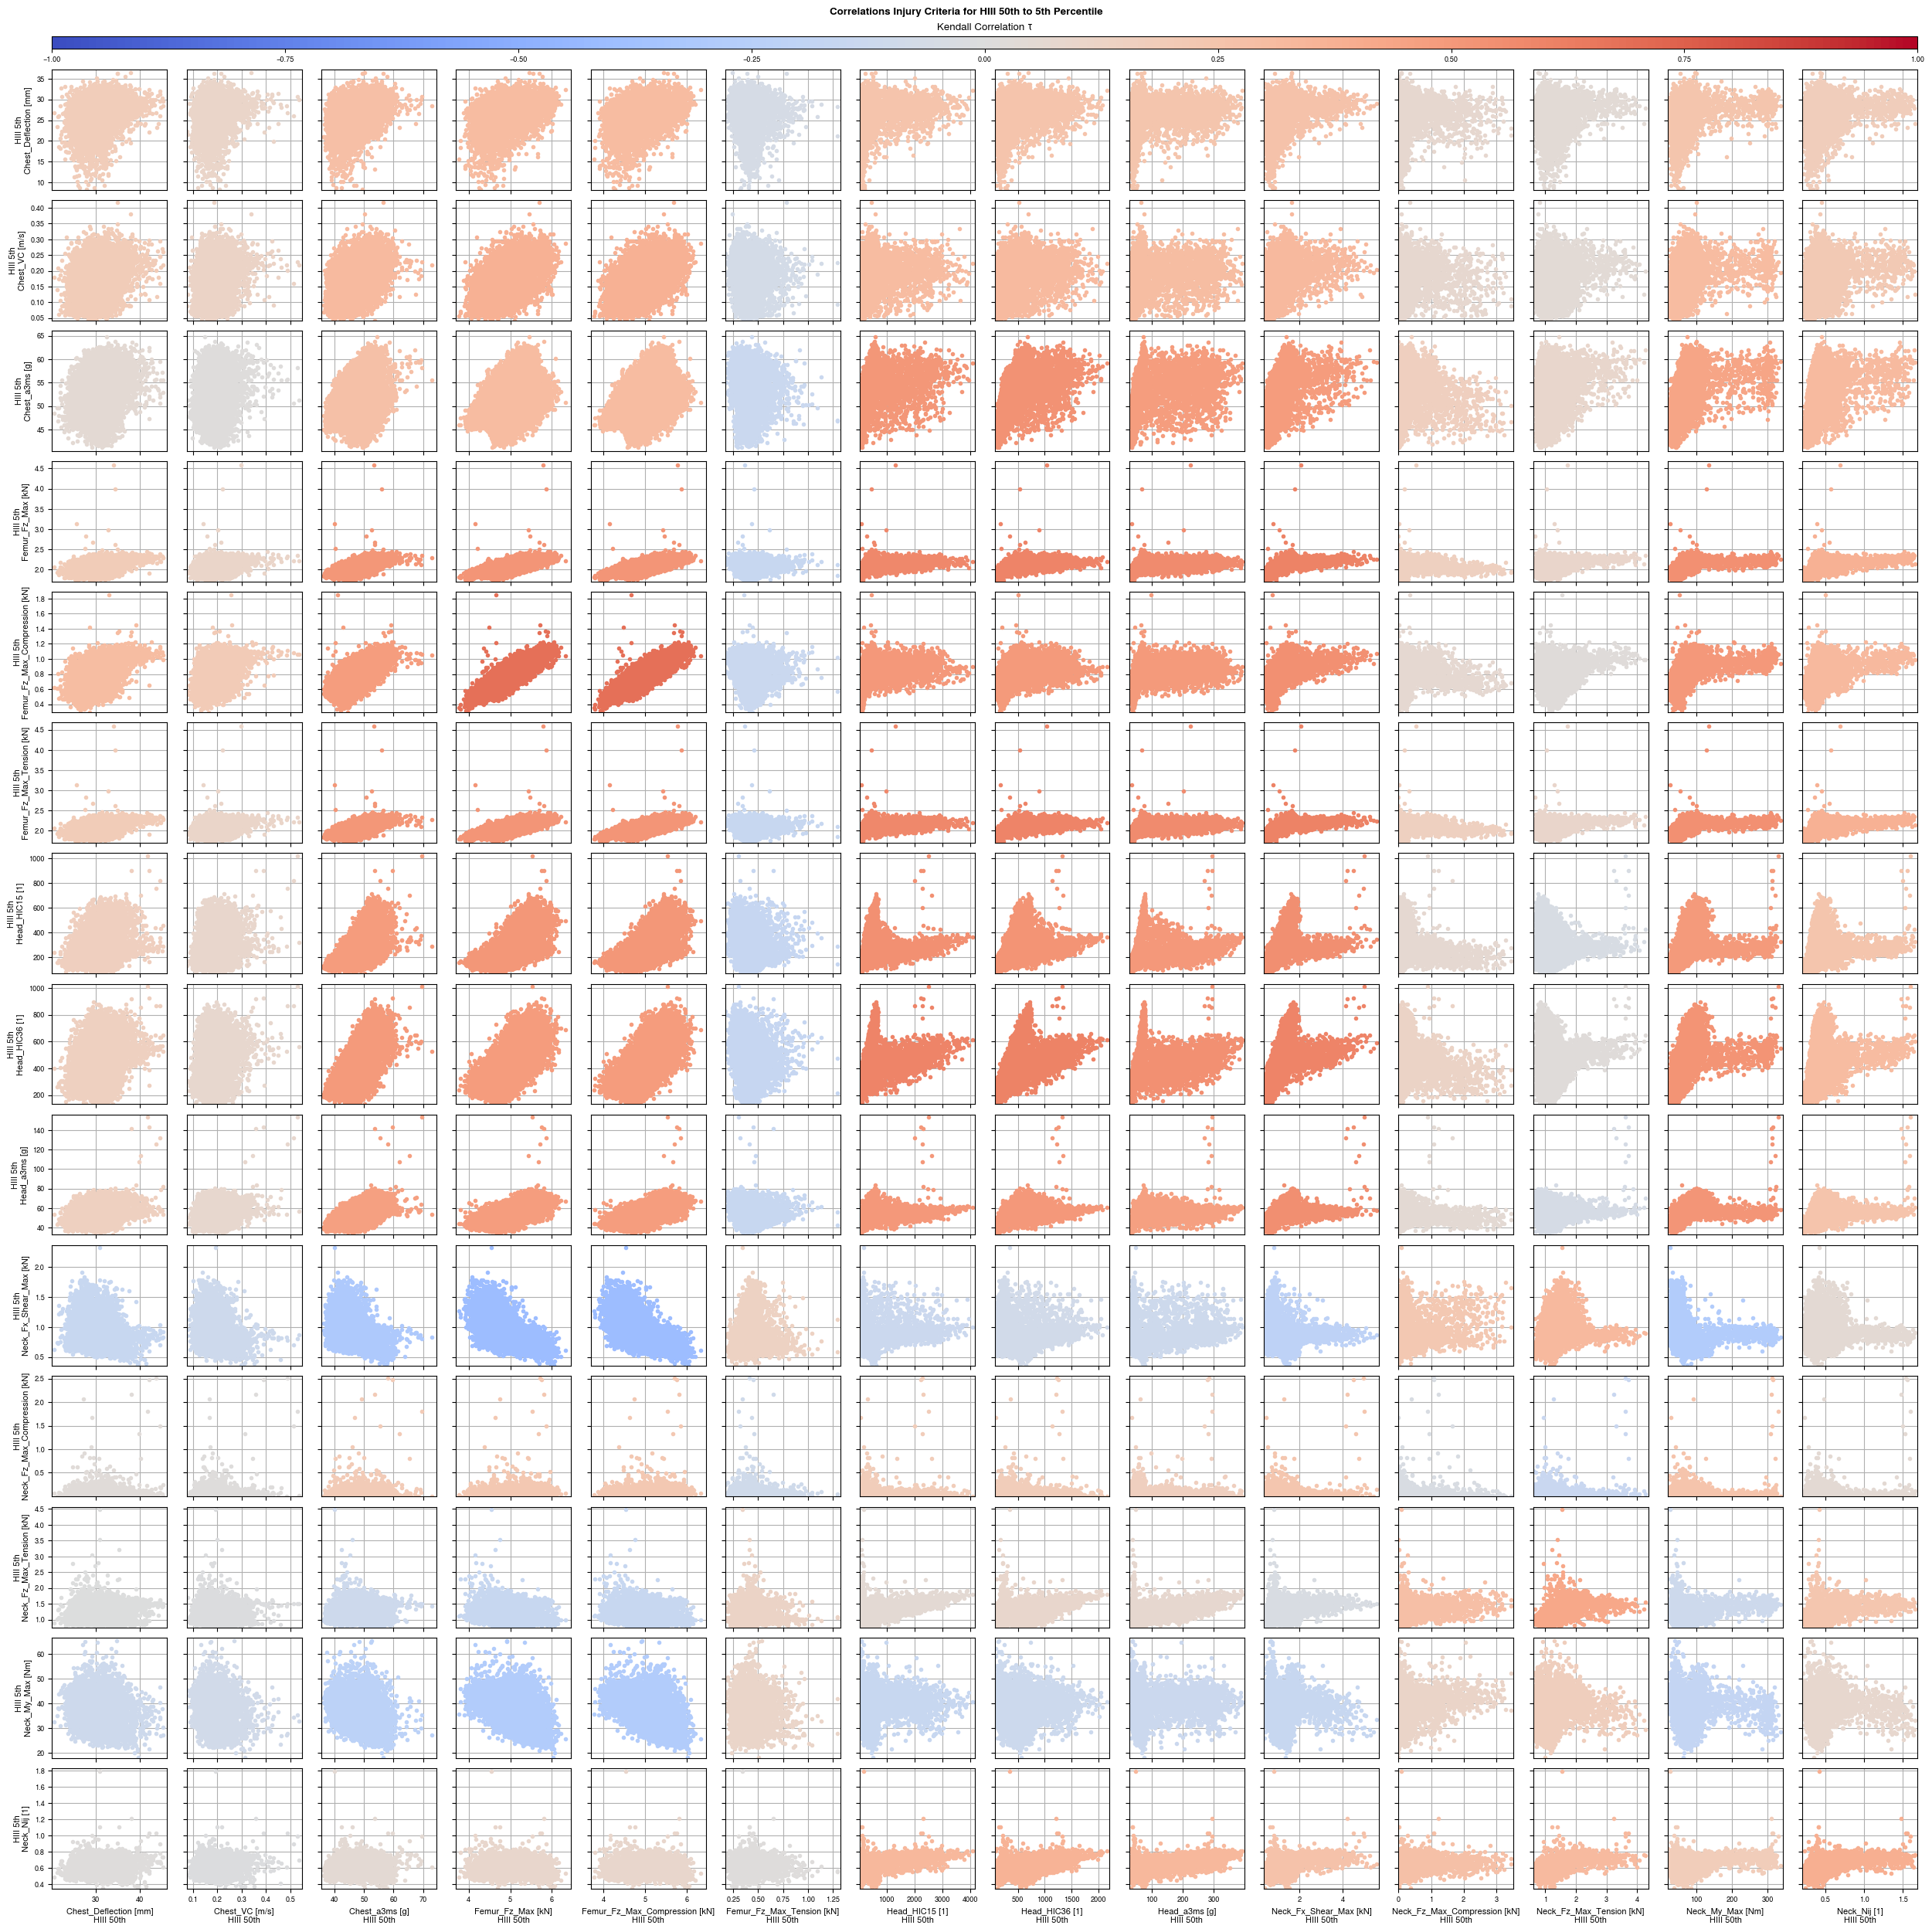

In [8]:
def to_50_fance(d_dir: Path, perc: int, cols=None):

    # data
    drops = json_util.load(f_path=d_dir / STR.fname_dropped_ids)
    drops = drops["50"] + drops[str(perc)]
    inj_vals_ = ParquetHandler(path=d_dir / STR.fname_injury_crit).read(columns=REL_COLS, percentiles=[perc, 50])
    if cols is None:
        inj_cols = sorted(inj_vals_.columns)
    else:
        inj_cols = sorted(cols)

    inj_vals_50 = inj_vals_.loc[(slice(None), 50), :].droplevel(STR.perc).drop(index=drops).copy()
    inj_vals_perc = inj_vals_.loc[(slice(None), perc), :].droplevel(STR.perc).drop(index=drops).copy()
    del inj_vals_

    # prepare plot
    p_width = ((448.13095 / 72) * 4) * (len(inj_cols) / inj_vals_50.shape[1])
    fields = [[f"{d}_{i}" for i in inj_cols] for d in inj_cols]
    fields = [["color"] * len(inj_cols)] + fields
    fig, ax = plt.subplot_mosaic(
        mosaic=fields,
        figsize=(p_width, p_width),
        layout="constrained",
        gridspec_kw={"height_ratios": (0.1, *([1] * len(inj_cols)))},
    )
    fig.suptitle(f"Correlations Injury Criteria for HIII 50th to {perc}th Percentile")

    # colorbar
    cmap = mpl.colormaps["coolwarm"]
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(mappable=sm, cax=ax["color"], orientation="horizontal")
    ax["color"].set_title("Kendall Correlation τ")

    # ranges
    inj_vals_50_ranges = {c: (inj_vals_50[c].min() * 0.98, inj_vals_50[c].max() * 1.02) for c in inj_vals_50.columns}
    inj_vals_perc_ranges = {c: (inj_vals_perc[c].min() * 0.98, inj_vals_perc[c].max() * 1.02) for c in inj_vals_perc.columns}

    # generate plot
    for inj_50_col, inj_perc_col in product(inj_cols, inj_cols):
        ax_ = ax[f"{inj_perc_col}_{inj_50_col}"]
        # plot
        cor = stats.kendalltau(inj_vals_50[inj_50_col].loc[inj_vals_perc.index], inj_vals_perc[inj_perc_col]).statistic
        ax_.scatter(
            inj_vals_50[inj_50_col].loc[inj_vals_perc.index], inj_vals_perc[inj_perc_col], color=cmap((cor + 1) * 0.5), marker="."
        )

        # format
        ax_.set_xlim(inj_vals_50_ranges[inj_50_col])
        ax_.set_ylim(inj_vals_perc_ranges[inj_perc_col])
        ax_.grid()
        ax_.set_axisbelow(True)
        if inj_50_col == inj_cols[0]:
            ax_.set_ylabel(f"HIII {perc}th\n{inj_perc_col} [{REL_COLS[inj_perc_col]}]")
        if inj_50_col != inj_cols[0]:
            ax_.set_yticklabels([])
        if inj_perc_col == inj_cols[-1]:
            ax_.set_xlabel(f"{inj_50_col} [{REL_COLS[inj_50_col]}]\nHIII 50th")
        if inj_perc_col != inj_cols[-1]:
            ax_.set_xticklabels([])

    # fig.tight_layout()


to_50_fance(d_dir=HIII_DIR, perc=5)

2024-09-14 17:30:32,390     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


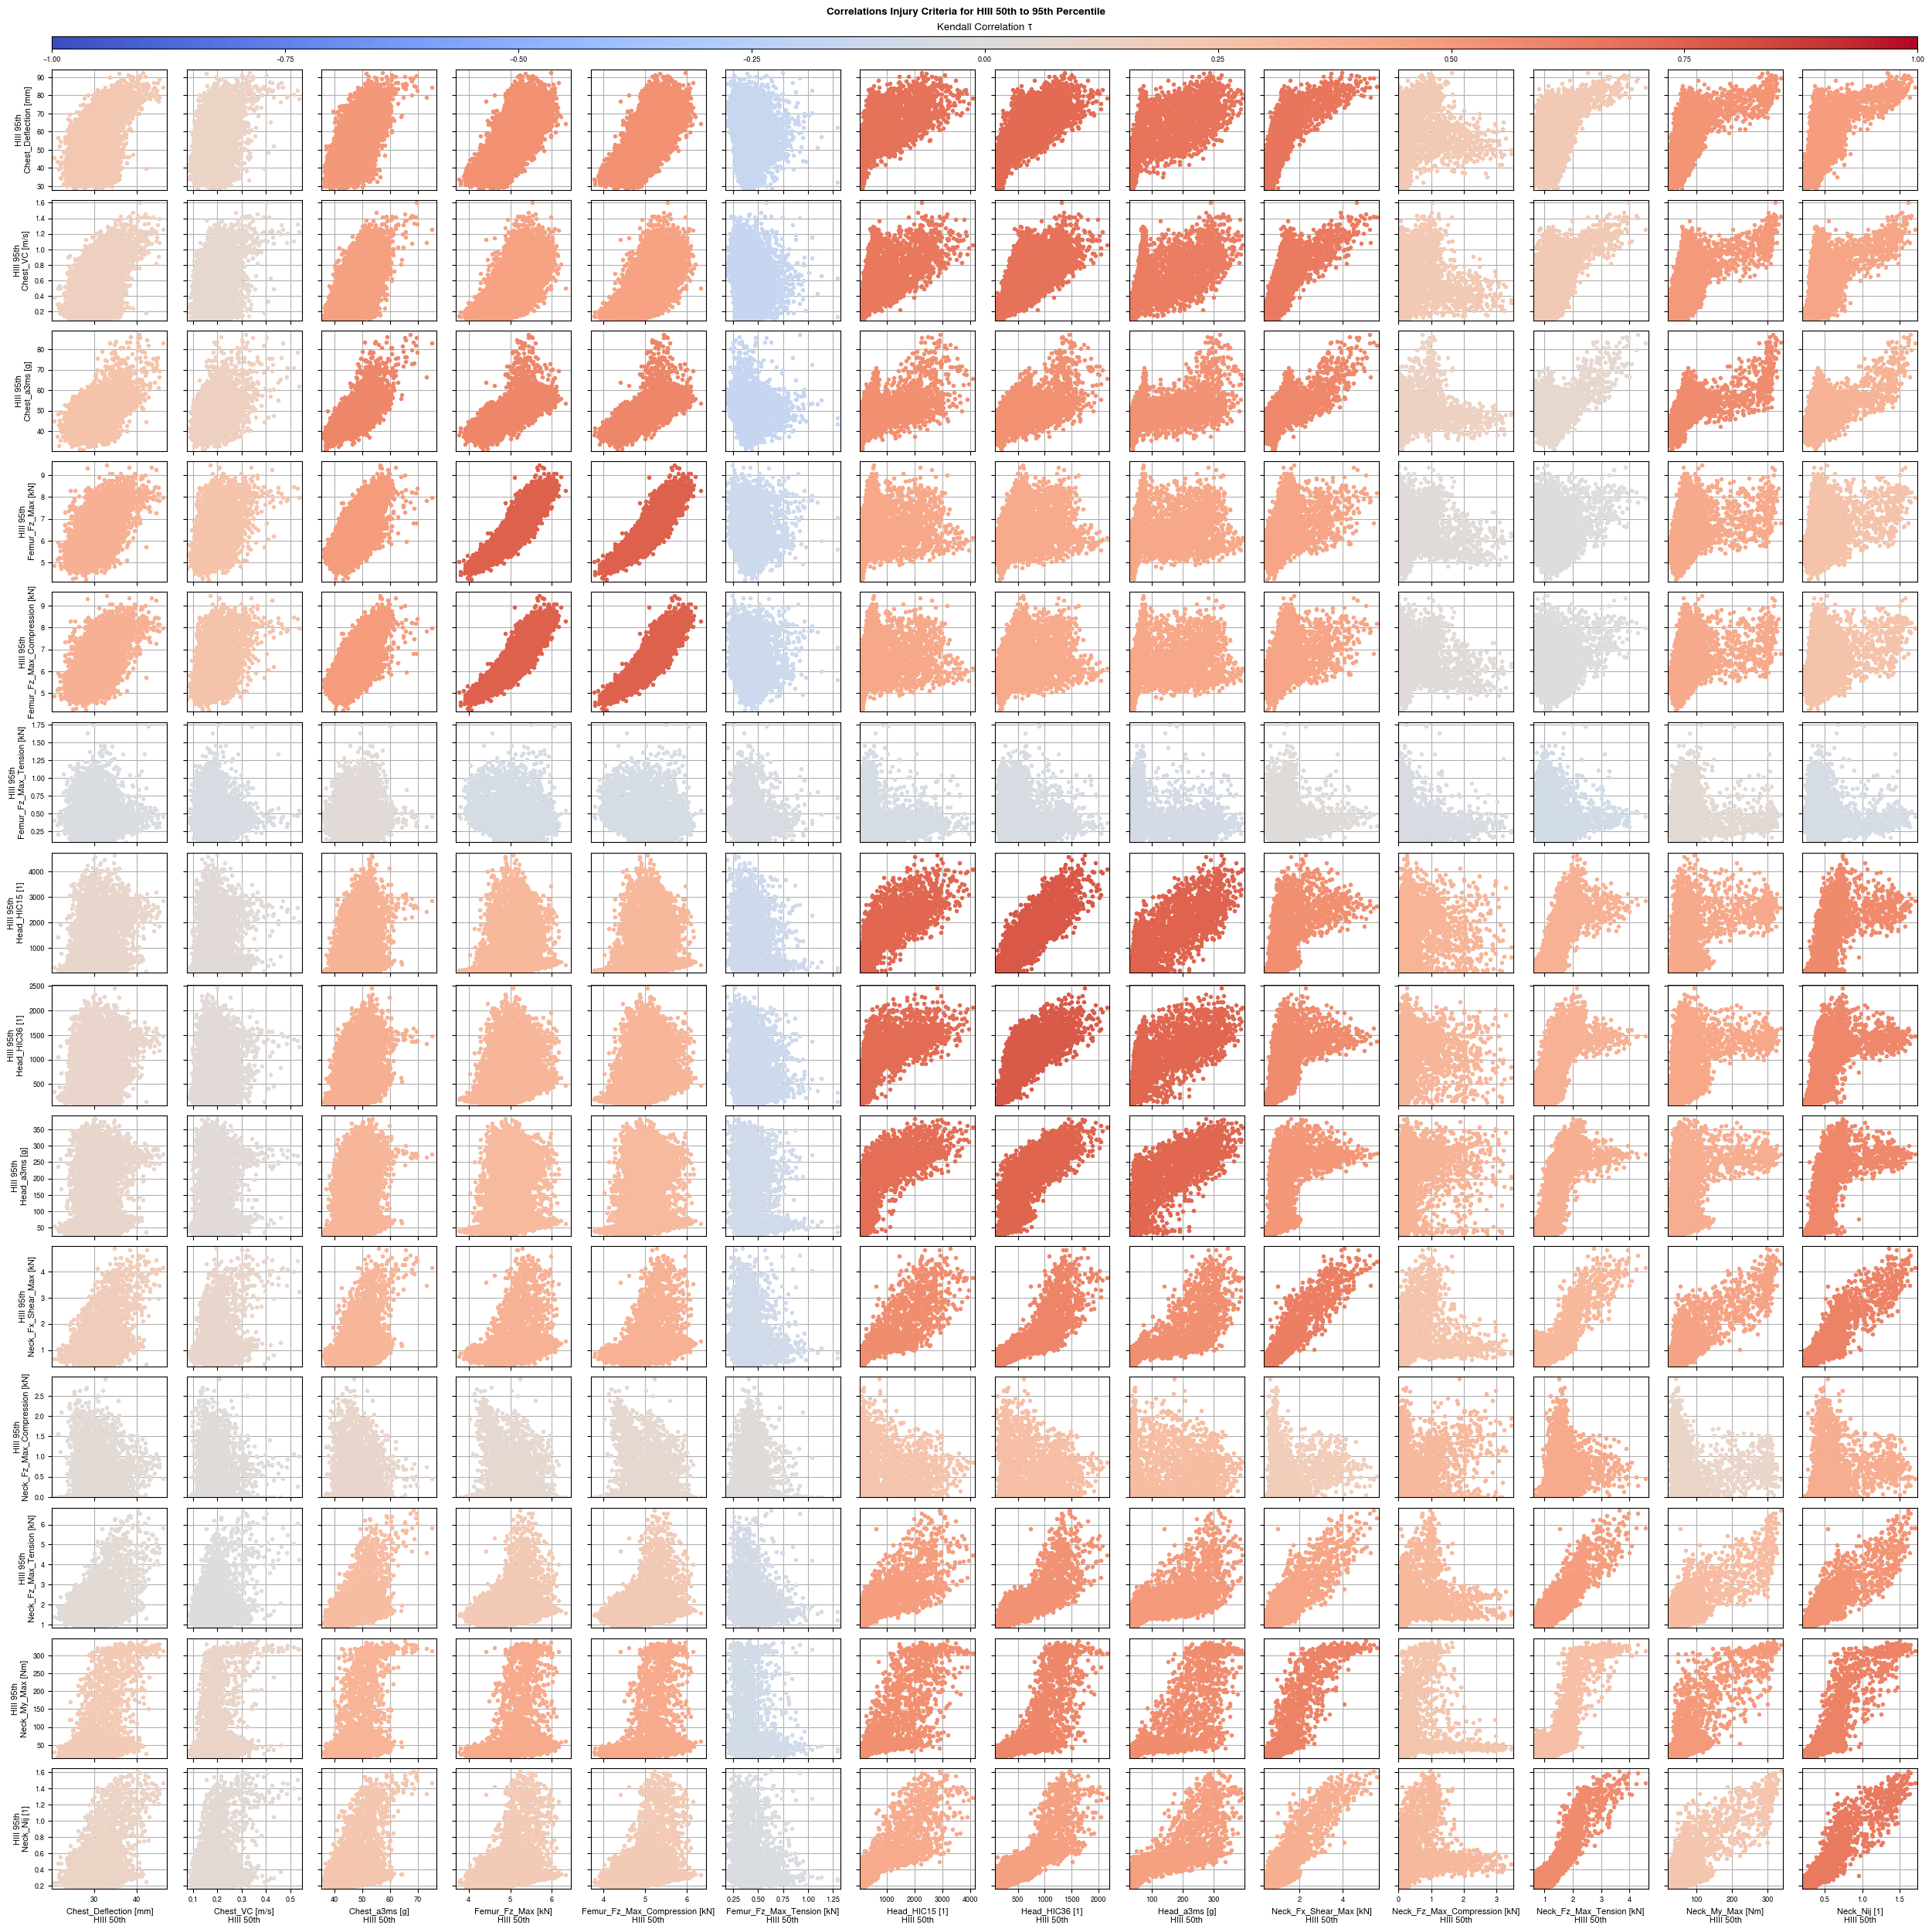

In [9]:
to_50_fance(d_dir=HIII_DIR, perc=95)

2024-09-14 17:31:04,314     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


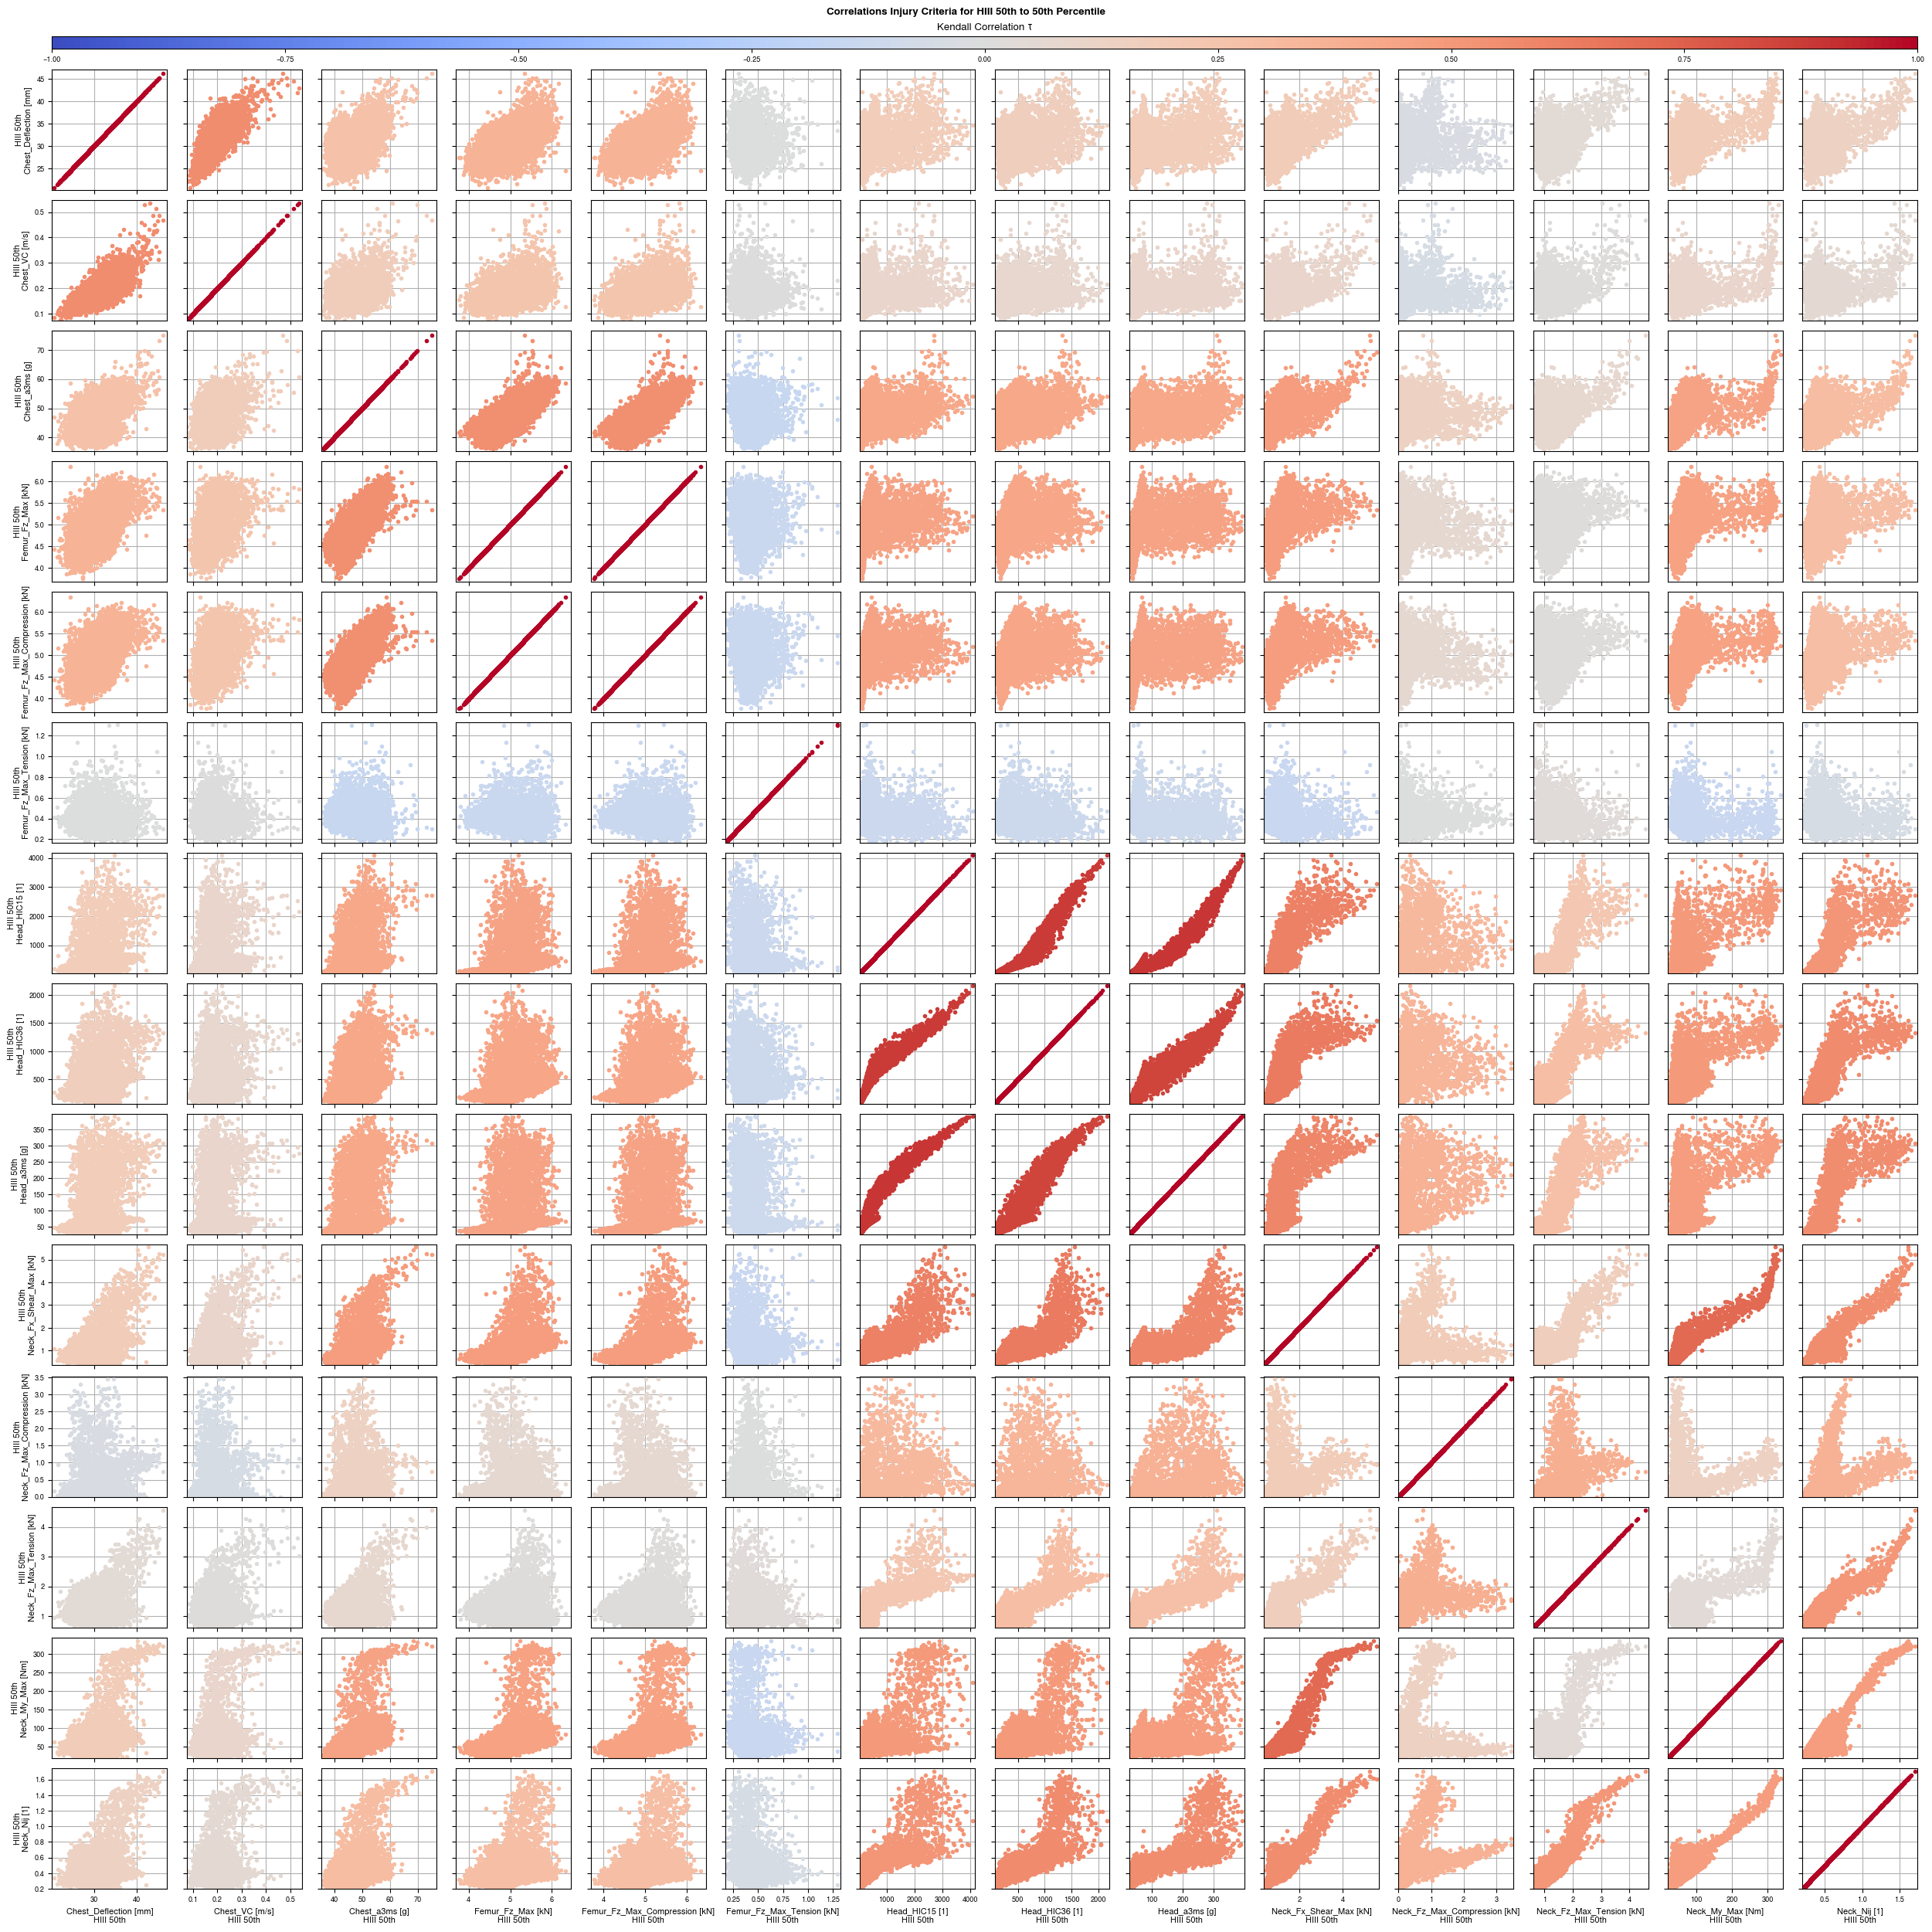

In [10]:
to_50_fance(d_dir=HIII_DIR, perc=50)

2024-09-14 17:31:35,712     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


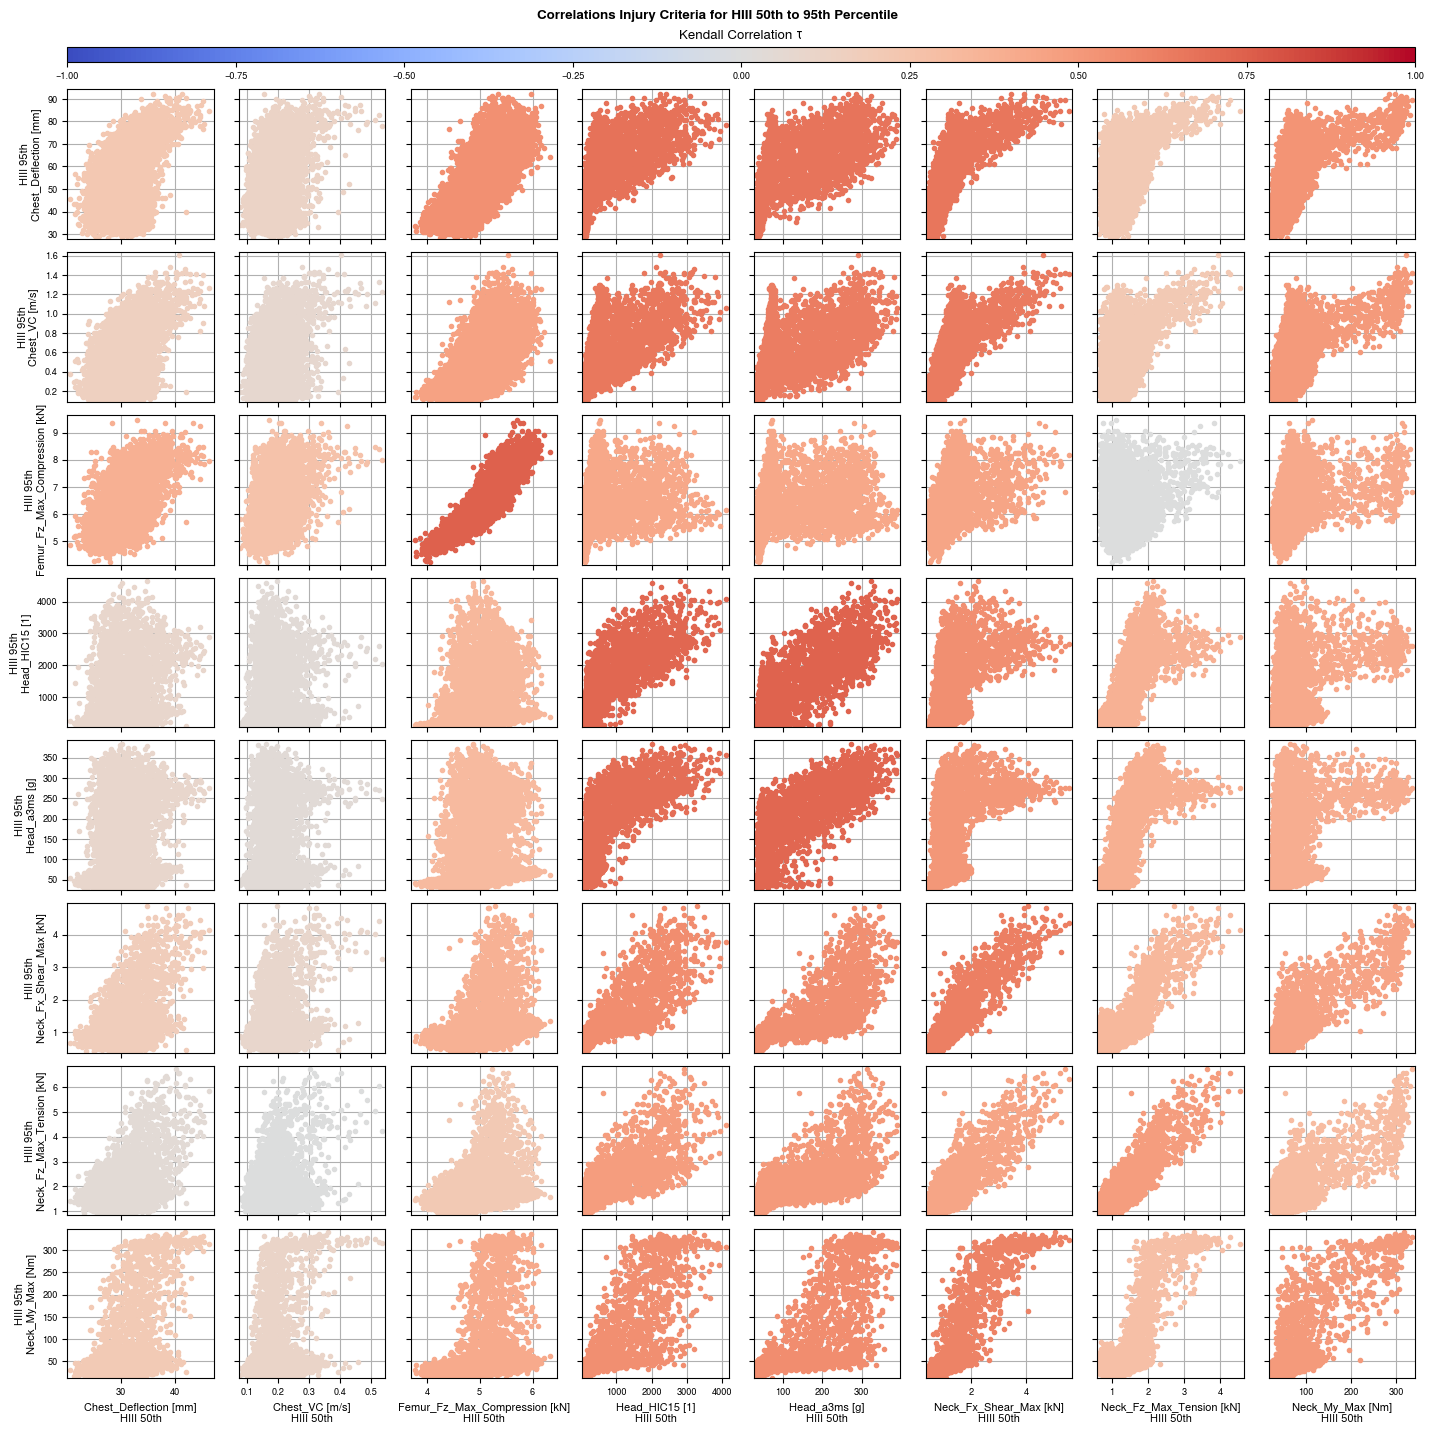

In [11]:
to_50_fance(
    d_dir=HIII_DIR,
    perc=95,
    cols=[
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Max",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Femur_Fz_Max_Compression",
        "Chest_VC",
    ],
)

2024-09-14 17:31:46,704     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


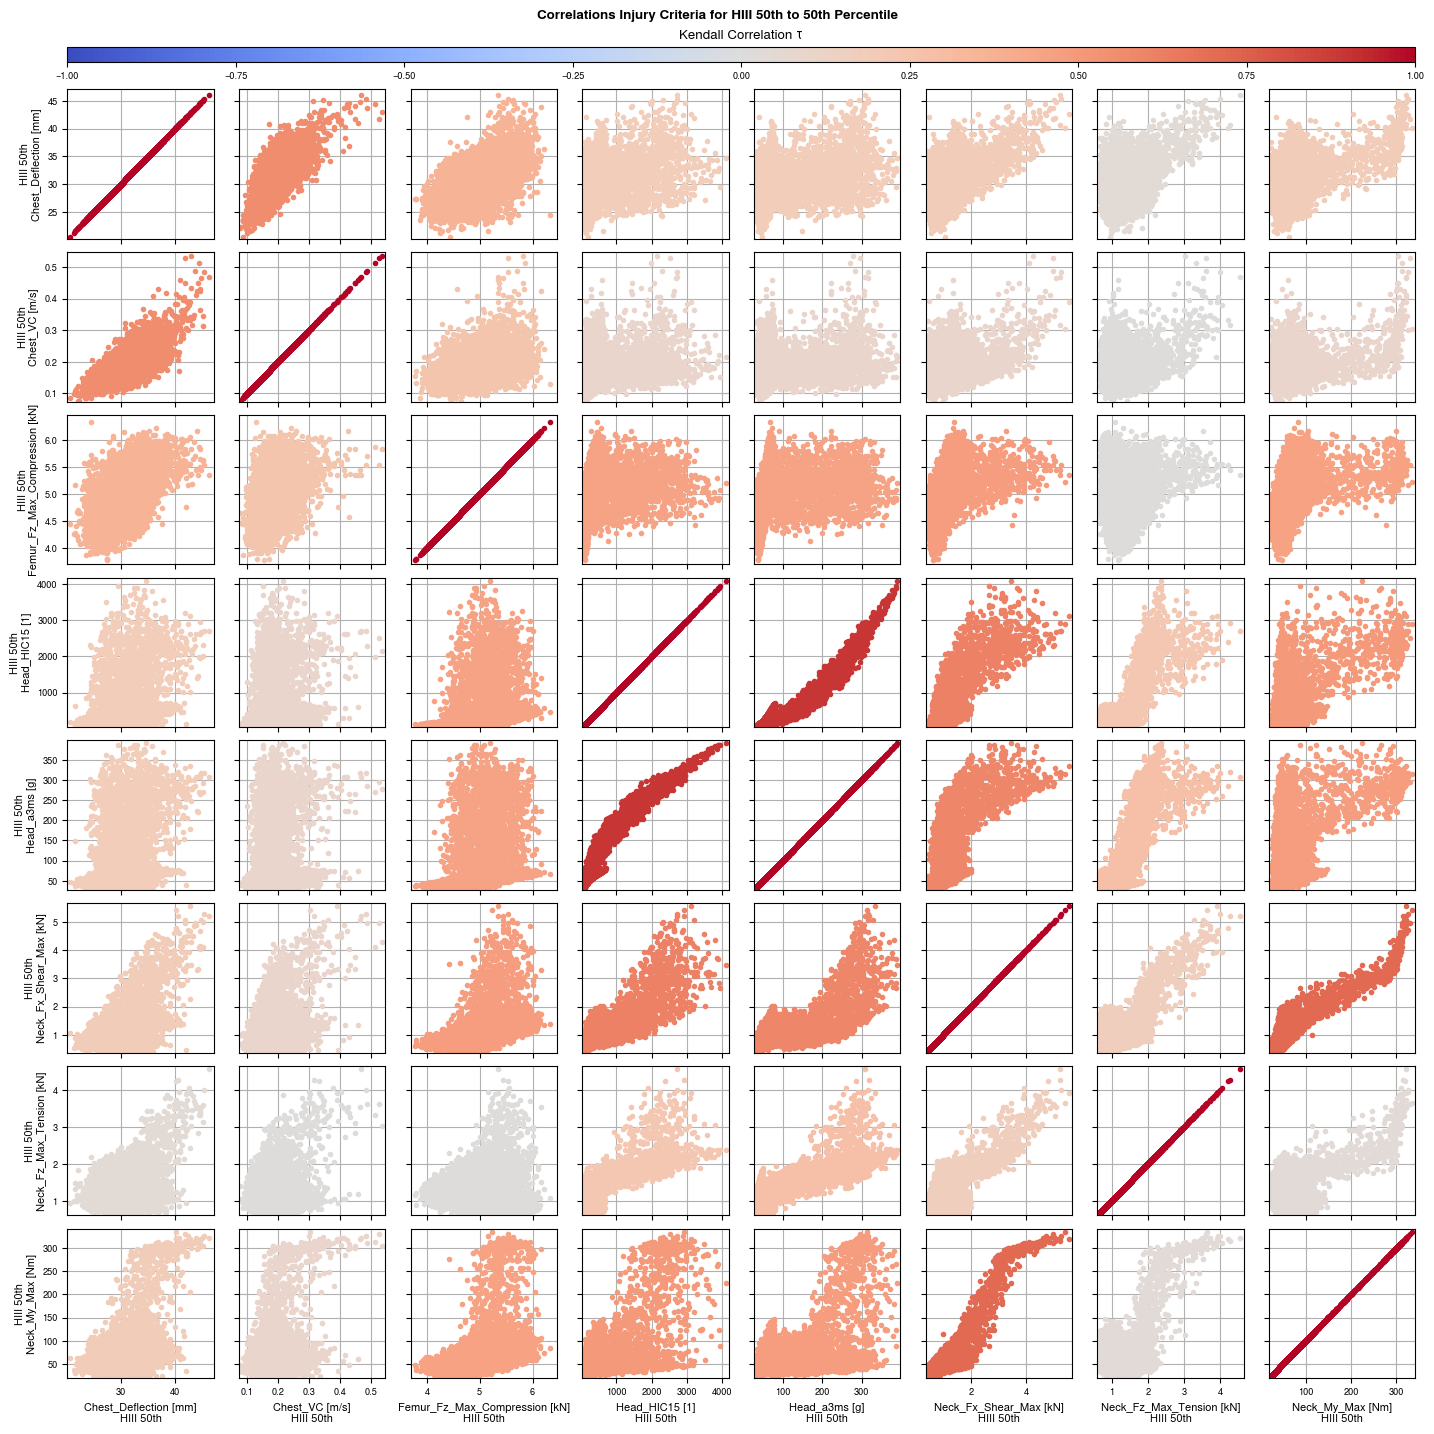

In [12]:
to_50_fance(
    d_dir=HIII_DIR,
    perc=50,
    cols=[
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Max",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Femur_Fz_Max_Compression",
        "Chest_VC",
    ],
)

2024-09-14 17:31:56,447     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists


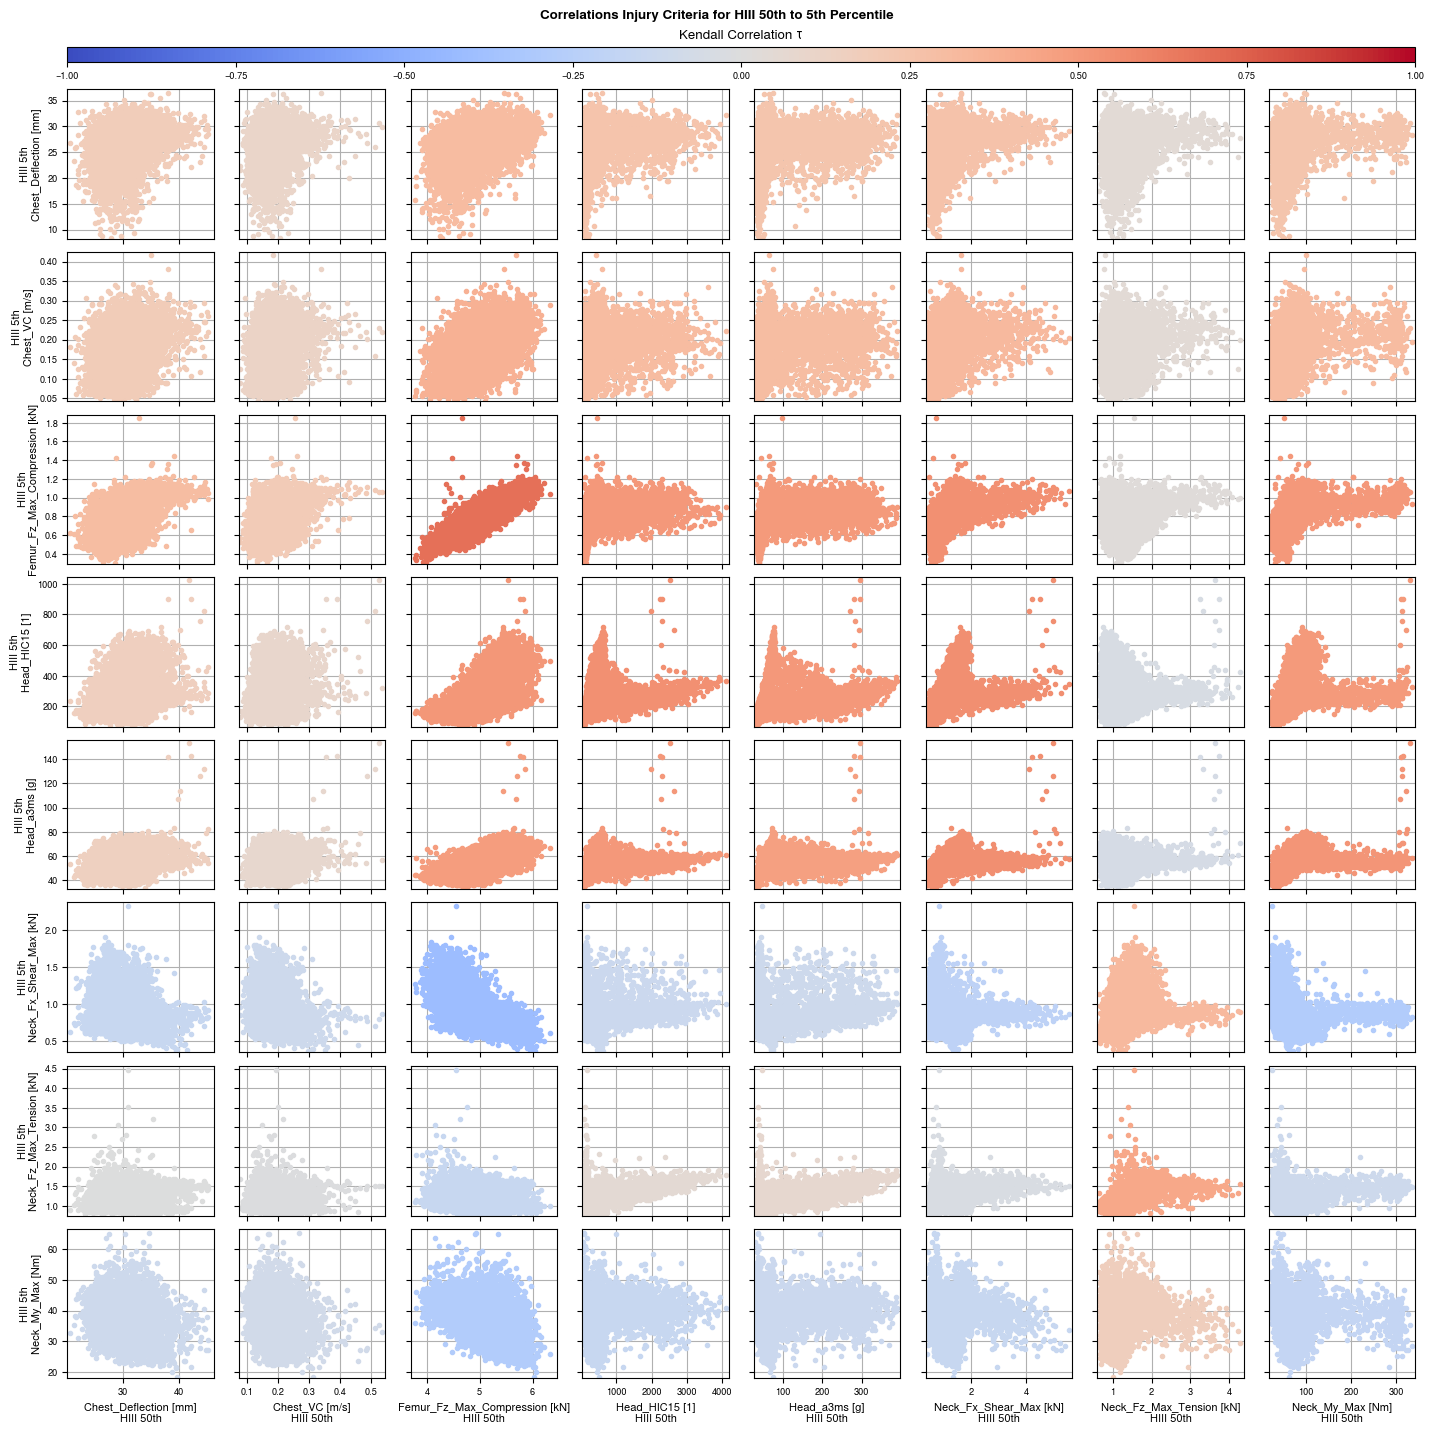

In [13]:
to_50_fance(
    d_dir=HIII_DIR,
    perc=5,
    cols=[
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Max",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Femur_Fz_Max_Compression",
        "Chest_VC",
    ],
)